In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [2]:
data = pd.read_csv('data/p4kreviews.csv', encoding='latin1')

In [27]:
data.head()
# data.describe()

,Unnamed: 0,album,artist,best,date,genre,review,score
0,1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
1,2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
2,3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
3,4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
4,5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngs ...",6.7


# Data Prep

In [17]:
grouped_by_artist = data.groupby(['artist'])
grouped_by_artist

In [21]:
# Remove "Various Artists" since doesn't give us insight into a single artist.
reviews = data[data.artist != "Various Artists"]

In [ ]:
#Convert date column to date values
reviews['date'] = pd.to_datetime(reviews['date'])

# Exploration

# Visualization

In [ ]:
# num reviews per year
reviews_by_year = reviews[['review']].groupby(reviews['date'].dt.year).count()
plt.bar(reviews_by_year.index, reviews_by_year['review'])
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

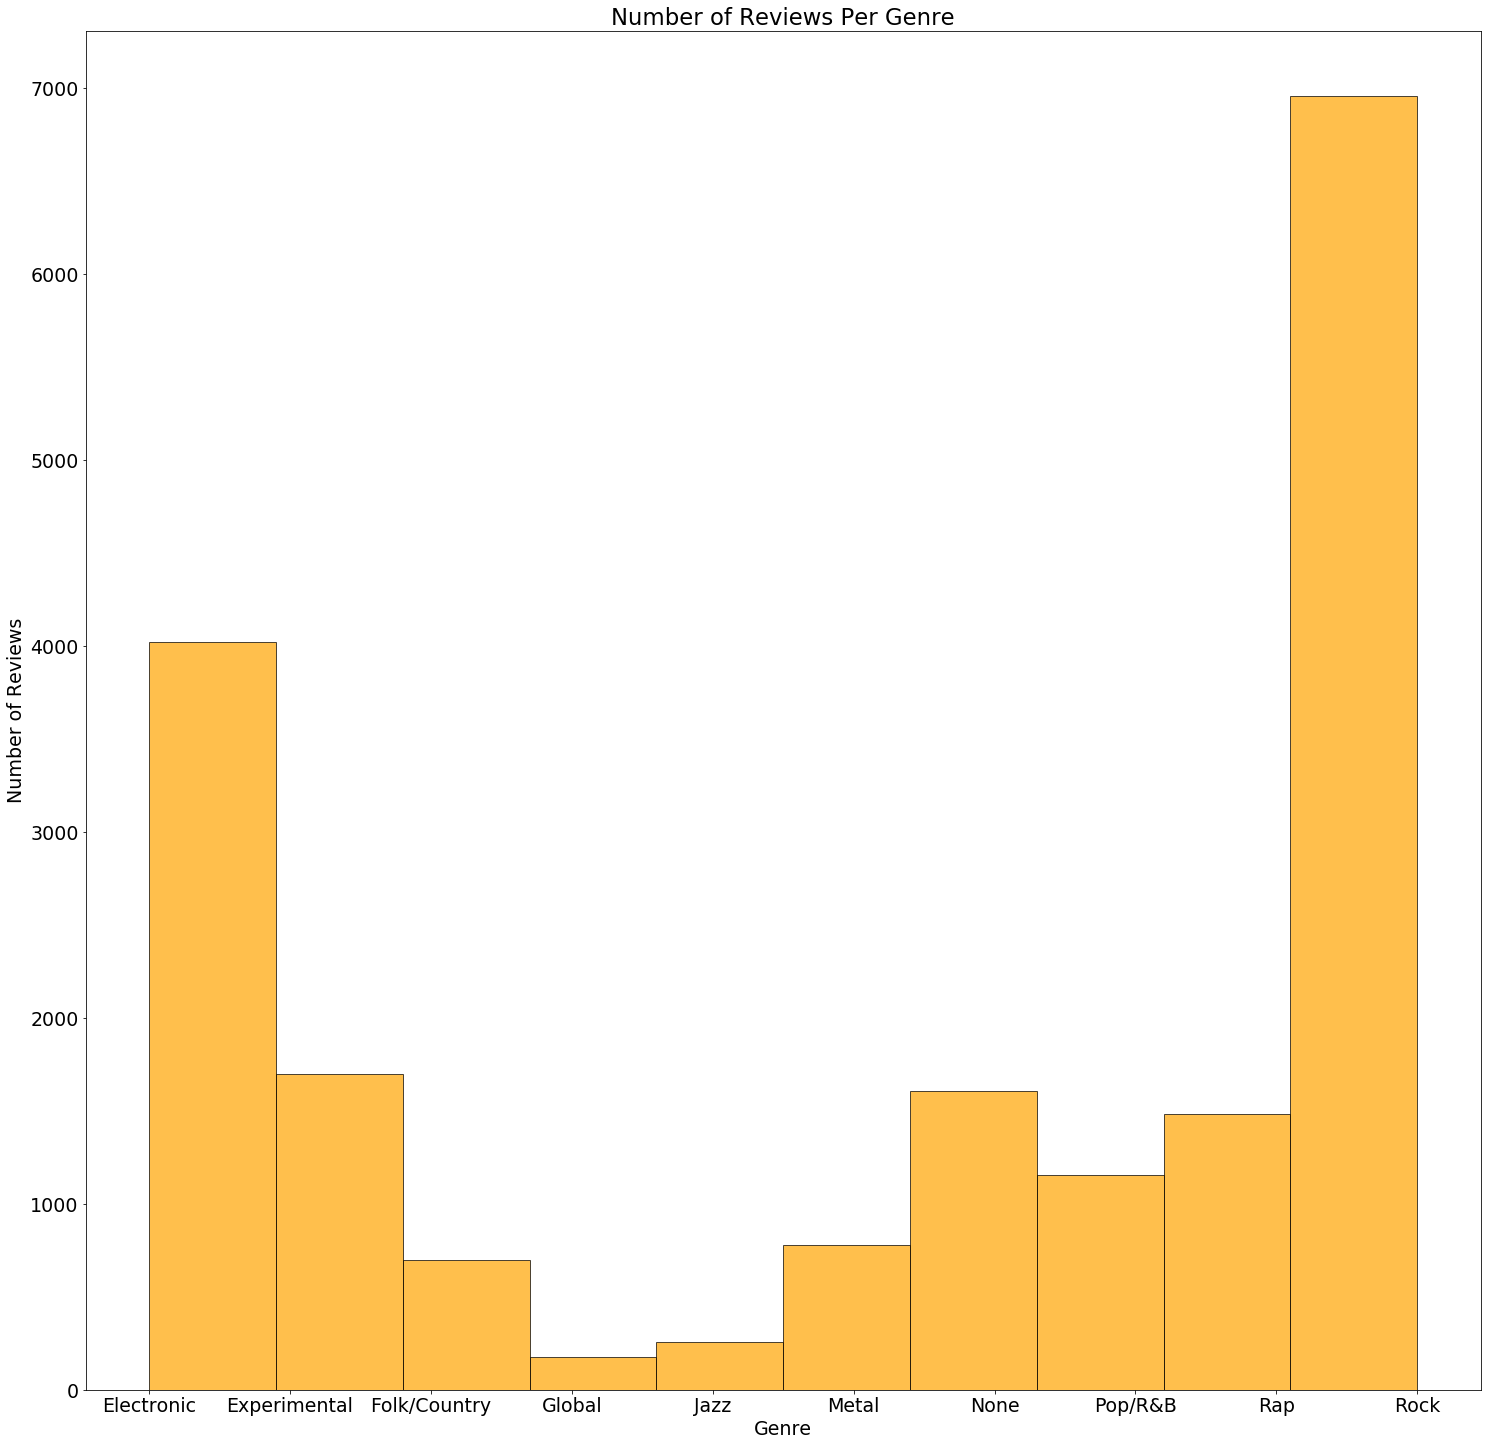

In [33]:
# number of reviews per genre
reviews

plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(reviews['genre'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Number of Reviews Per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Reviews")
plt.show()

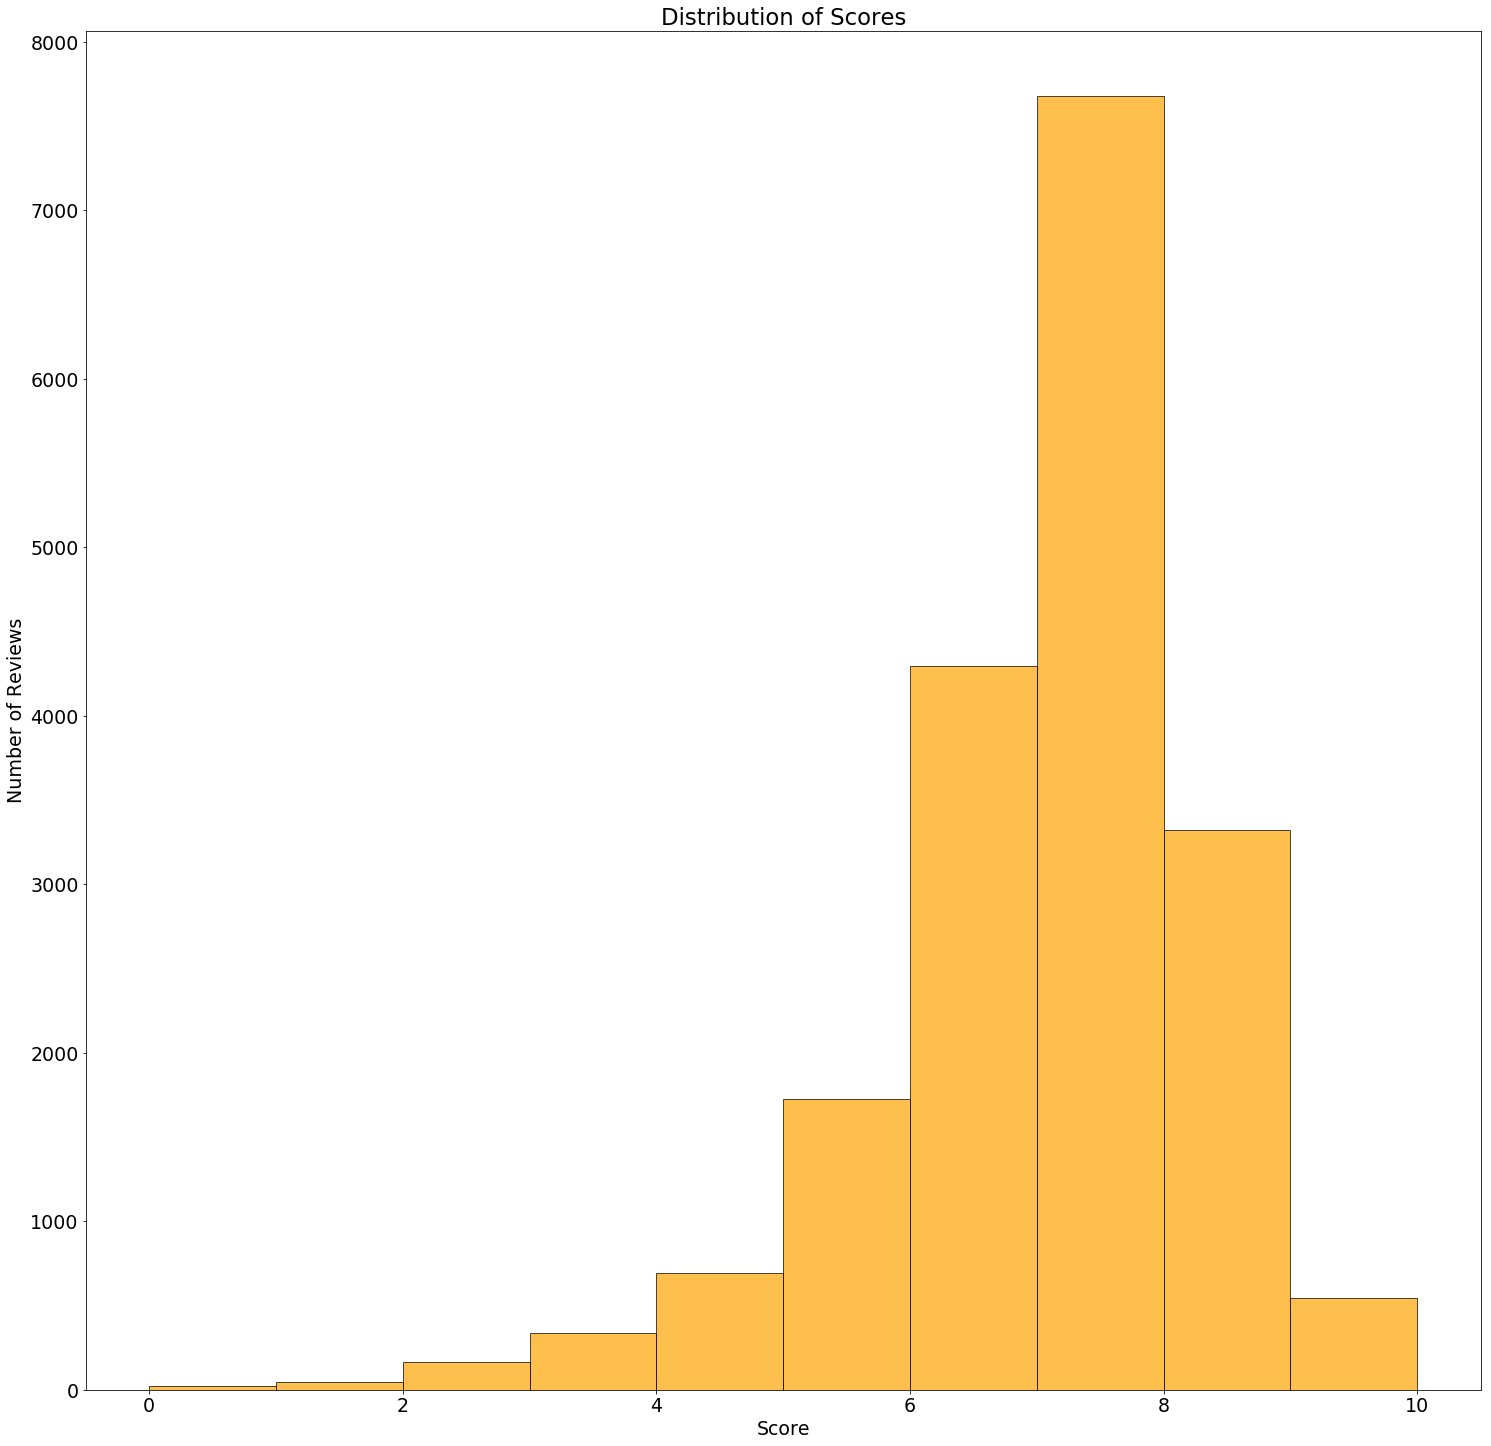

In [103]:
# Distribution of scores
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(reviews['score'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

In [98]:
# Count the words in the reviews -- takes a long time
count_array = []
for i in reviews.index:
    count = len(nltk.word_tokenize(str(reviews["review"][i])))
    count_array.append(count)
reviews["review_word_count"] = count_array

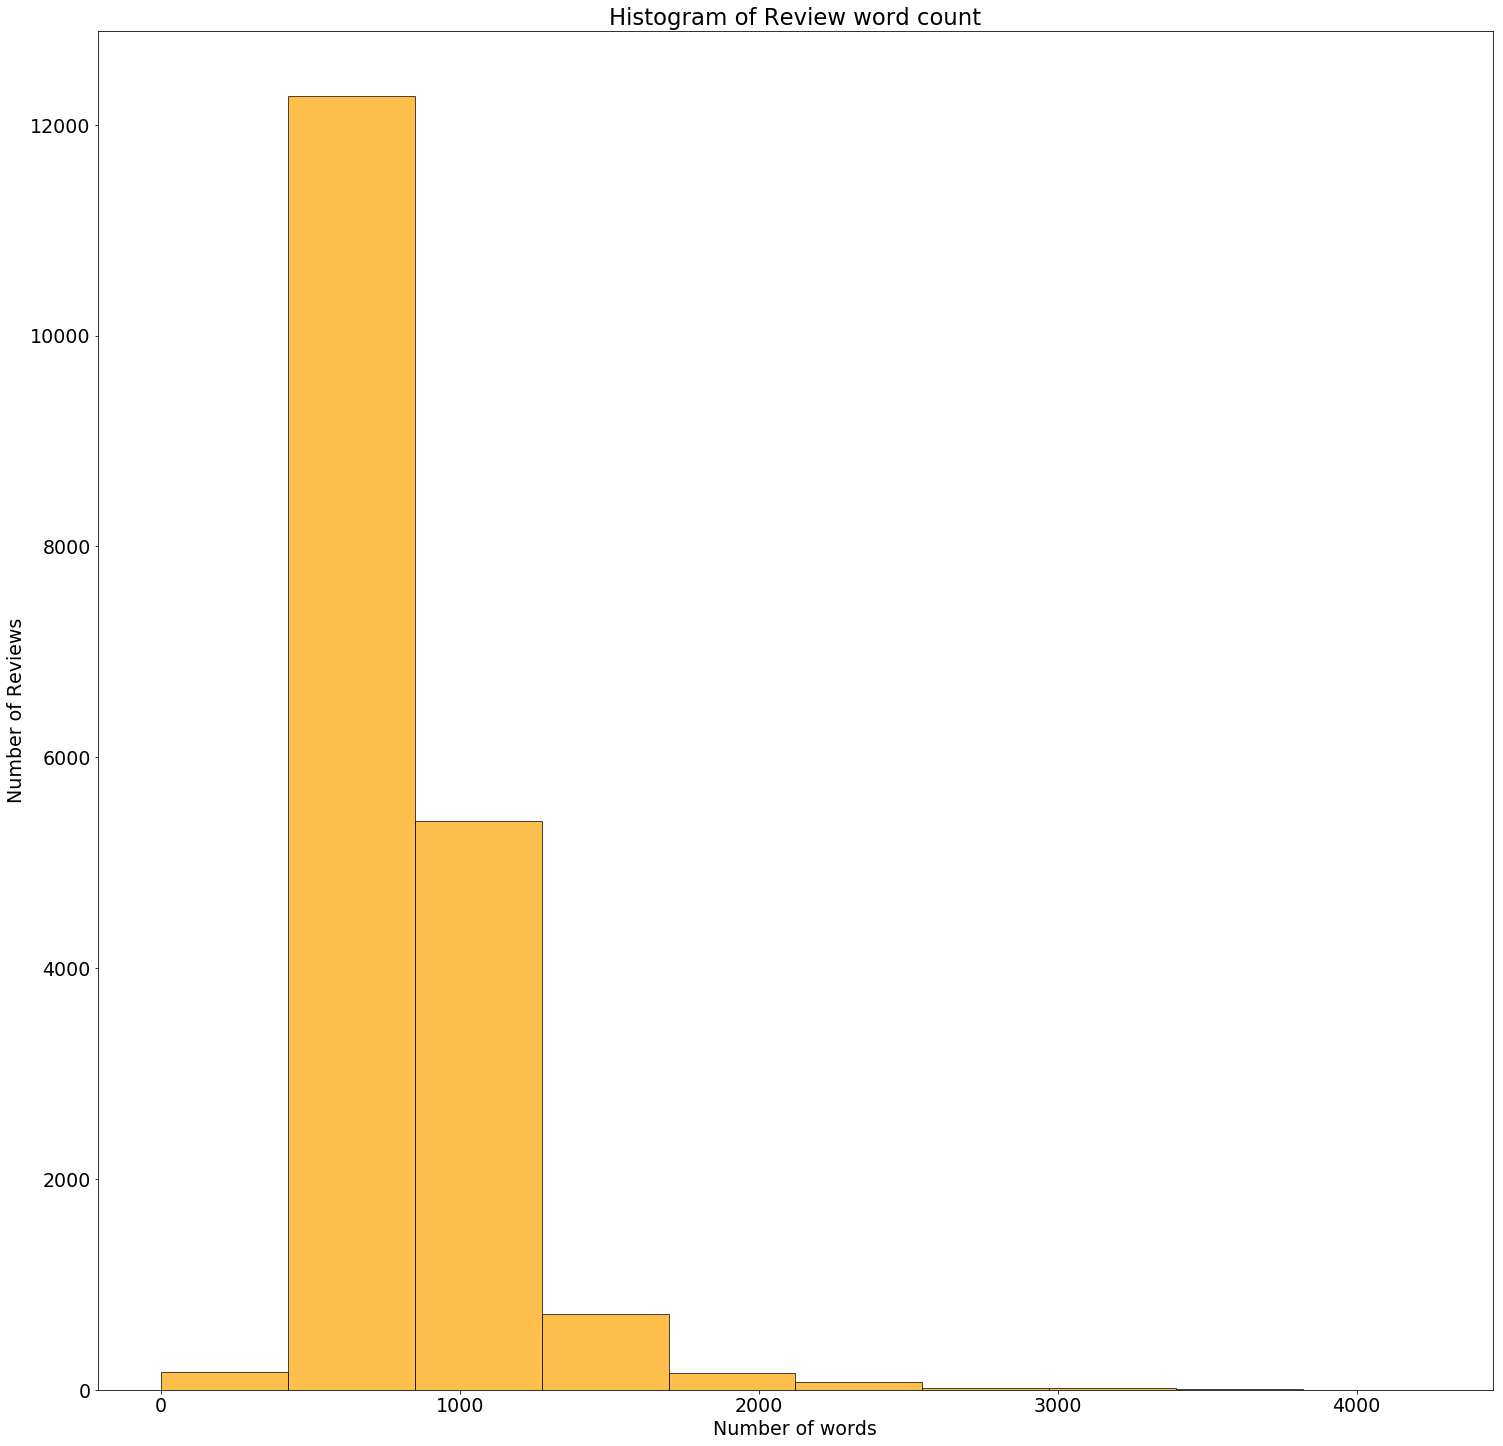

In [104]:
# Distribution of word count for reviews
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(reviews['review_word_count'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Histogram of Review word count")
plt.xlabel("Number of words")
plt.ylabel("Number of Reviews")
plt.show()

# Analysis